In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cross_validation, linear_model, preprocessing
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
from __future__ import division
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
%matplotlib inline

In [5]:
data = pd.read_csv('./sw_classifications_20160526-afterdedupe.csv')

In [6]:
gb = data.groupby(['swi_id', 'swj_id'])
groups = gb.groups
more_3 = {key: value for key, value in groups.iteritems() if len(value) >= 3}
more_2 = {key: value for key, value in groups.iteritems() if len(value) >= 2}
print 'Number of unique sidewalk pair labels: {}'.format(len(groups))
print 'Number of labels with more than 3 responses: {}'.format(len(more_3))
print 'Number of labels with 2 responses: {}'.format(len(more_2)-len(more_3))

Number of unique sidewalk pair labels: 11132
Number of labels with more than 3 responses: 862
Number of labels with 2 responses: 976


In [7]:
def label_fraction(sw_labelset):
    '''
    :param sw_labelset: List of 't' (True) or 'f' (False) labels for a single sidewalk pair.
    :type sw_labelset: list
    
    '''
    tf = data.iloc[sw_labelset, :]['connected']
    fraction_t = sum([1 for label in tf if label == 't']) / float(len(sw_labelset))
    
    return fraction_t

def decide_label(fraction):
    '''Decide how to label a given sidewalk pair given multiple responses.'''
    # If majority is 't', choose 't'
    if fraction > 0.5:
        return 't'
    # If majority is 'f', choose 'f'
    elif fraction < 0.5:
        return 'f'
    # If even split, ignore entirely for now
    else:
        return None

In [8]:
fractions2 = []
labels2 = []
for key, value in more_2.iteritems():
    fraction = label_fraction(value)
    label = decide_label(fraction)
    if label is not None:
        newrow = data.ix[value[0],['swi_id', 'swj_id', 'connected']]
        newrow['connected'] = label
        labels2.append(newrow)
        fractions2.append(fraction)

labels2 = pd.DataFrame(labels2)
labels2.head()

,swi_id,swj_id,connected
6276,325902,326474,f
736,326184,326185,f
2548,297773,303110,f
1925,322238,330093,f
10184,319771,320091,t


In [9]:
fractions3 = []
labels3 = []
for key, value in more_3.iteritems():
    fraction = label_fraction(value)
    label = decide_label(fraction)
    if label is not None:
        newrow = data.ix[value[0],['swi_id', 'swj_id', 'connected']]
        newrow['connected'] = label
        labels3.append(newrow)
        fractions3.append(fraction)

labels3 = pd.DataFrame(labels3)
labels3.head()

,swi_id,swj_id,connected
6276,325902,326474,f
1567,329341,329342,f
6772,302721,302737,f
736,326184,326185,f
7681,328733,328748,f


In [52]:
raw_data = pd.read_csv('./learndata-latest.csv')
raw_data.head()
crowd_labels = labels2
crowd_labels.head()
raw_data2 = pd.DataFrame()

True_disagree = 0. 
False_disagree = 0. 

NoConn = sum(raw_data['connected'])
NotConn = len(raw_data) - NoConn + 0. 

crowd_labels = crowd_labels.reset_index()

for i in range(0,len(crowd_labels)):
    temp = raw_data[raw_data['id_i']==crowd_labels['swi_id'][i]]
    temp2 = temp[temp['id_j']==crowd_labels['swj_id'][i]]
    raw_data2 = raw_data2.append(temp2,ignore_index=True)
    

    if (i%1000==0):
        print i
temp = pd.DataFrame({'Hlab' : raw_data2['connected']})
raw_data2 = pd.concat([temp,raw_data2],axis=1)
raw_data2['connected']=crowd_labels['connected']
raw_data2.head()

# Remove features that we shouldn't learn (encoded geometries and sidewalk ID numbers)
near_line = raw_data2['near_line']  # Save for later
del raw_data2['near_line']
del raw_data2['id_i']
del raw_data2['id_j']

# Binarizes categorical variables 
# (e.g. if 3 categories, makes 3 cols with 1s and 0s)
# X = pd.get_dummies(raw_data)  

# Turn categorical variables into integer labels
label_encoder = preprocessing.LabelEncoder()
raw_data2['curbtype_i'] = label_encoder.fit_transform(raw_data2['curbtype_i'])
raw_data2['curbtype_j'] = label_encoder.fit_transform(raw_data2['curbtype_j'])
raw_data2['side_i'] = label_encoder.fit_transform(raw_data2['side_i'])
raw_data2['side_j'] = label_encoder.fit_transform(raw_data2['side_j'])
raw_data2['surftype_i'] = label_encoder.fit_transform(raw_data2['surftype_i'])
raw_data2['surftype_j'] = label_encoder.fit_transform(raw_data2['surftype_j'])
raw_data2['intersects'] = label_encoder.fit_transform(raw_data2['intersects'])

X = raw_data2

X['same_curbtype'] = (X['curbtype_i'] == X['curbtype_j']).astype(int)
X['same_surftype'] = (X['surftype_i'] == X['surftype_j']).astype(int)
X['same_block'] = (X['bid_i'] == X['bid_j']).astype(int)
X['same_side'] = (X['side_i'] == X['side_j']).astype(int)

# TODO: There's probably more features we can generate with these two lengths
X['length_diff'] = abs(X['length_i'] - X['length_j'])
X['sw_width_diff'] = abs(X['sw_width_i'] - X['sw_width_j'])

y = X['connected']
X = X.drop('connected', 1)
X = X.drop('curbtype_i', 1)
X = X.drop('curbtype_j', 1)
X = X.drop('surftype_i', 1)
X = X.drop('surftype_j', 1)

X['near_angle'] = abs(X['near_angle'])

del X['bid_i']  # This has NaN and will cause errors in sklearn
del X['bid_j']

del X['side_i']
del X['side_j']
del X['length_i']
del X['length_j']
del X['sw_width_i']
del X['sw_width_j']

X.head()

# Scaling appropriate features by subtracting mean and scaling to unit variance
scaler = preprocessing.StandardScaler()

X['near_distance'] = scaler.fit_transform(X['near_distance'])
X['length_diff'] = scaler.fit_transform(X['length_diff'])
X['sw_width_diff'] = scaler.fit_transform(X['sw_width_diff'])


0
1000


c:\python27\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\python27\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\python27\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains

In [53]:
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=6883)

poly = preprocessing.PolynomialFeatures(2)
Xp = poly.fit_transform(X)
Xp_train, Xp_test, yp_train, yp_test = cross_validation.train_test_split(Xp, y, test_size=0.5, random_state=6883)


In [149]:
svmc = svm.SVC(C=1, kernel = 'linear',probability=False)
svmc.fit(Xp_train, y_train)
print svmc.score(Xp_test, yp_test)
svmc_pred = svmc.predict(Xp_test)
print precision_score(yp_test, svmc_pred)
print recall_score(yp_test, svmc_pred)

0.966555183946
0.983146067416
0.866336633663


c:\python27\lib\site-packages\sklearn\svm\base.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


c:\python27\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.966555183946
Precision score (what fraction of predicted connections are true): 0.967391304348
Recall score (what fraction of connections were found?): 0.881188118812


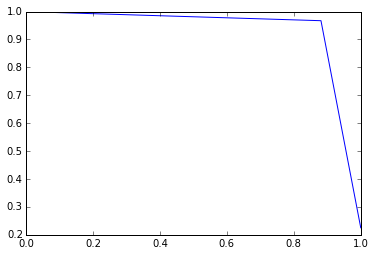

In [55]:
logisticp = linear_model.LogisticRegression(penalty='l1', C=0.001)
logisticp.fit(Xp_train, yp_train)
print logisticp.score(Xp_test, yp_test)
yp_pred = logisticp.predict(Xp_test)
Prob = logisticp.predict_proba(Xp_test)
precisionp, recallp, thresholdsp = precision_recall_curve(yp_test, yp_pred)
print "Precision score (what fraction of predicted connections are true): {}".format(precision_score(yp_test, yp_pred))
print "Recall score (what fraction of connections were found?): {}".format(recall_score(yp_test, yp_pred))

plt.plot(recallp, precisionp)
plt.show()

In [165]:
#get probabilities for each class 

LowClass1 = Prob[:,0]<0.99
LowClass2 = Prob[:,1]<0.99
Ambig = (LowClass1==LowClass2)
HighClass1 = Prob[:,0]>0.99
HighClass2 = Prob[:,1]>0.99

In [166]:
#calculate efficiency in non-ambiguous
NonAmbigIn = np.logical_or(HighClass1, HighClass2)
print logisticp.score(Xp_test[NonAmbigIn], yp_test[NonAmbigIn])
l_pred = logisticp.predict(Xp_test[NonAmbigIn])
print precision_score(yp_test[NonAmbigIn], l_pred)
print recall_score(yp_test[NonAmbigIn], l_pred)

0.991967871486
1.0
0.95


In [167]:
#calculate efficiency ambiguous
print logisticp.score(Xp_test[Ambig], y_test[Ambig])
l_pred = logisticp.predict(Xp_test[Ambig])
print precision_score(y_test[Ambig], l_pred)
print recall_score(y_test[Ambig], l_pred)


0.84
0.914285714286
0.780487804878


In [154]:
#see fraction of ambiguous 1's 
Ambig1 = sum(yp_test[Ambig])/sum(yp_test)
print Ambig1
#fraction of unambiguous 1's 
print 1- Ambig1

[ 0.40594059]
[ 0.59405941]


In [155]:
len(yp_test[Ambig])

150

In [61]:
raw_data = pd.read_csv('./learndata-latest.csv')
raw_data.head()
crowd_labels = labels2
crowd_labels = pd.read_csv('./crowdsource-20160208.csv')
crowd_labels.head()
raw_data2 = pd.DataFrame()

True_disagree = 0. 
False_disagree = 0. 

NoConn = sum(raw_data['connected'])
NotConn = len(raw_data) - NoConn + 0. 

crowd_labels = crowd_labels.reset_index()

for i in range(0,len(crowd_labels)):
    temp = raw_data[raw_data['id_i']==crowd_labels['swi_id'][i]]
    temp2 = temp[temp['id_j']==crowd_labels['swj_id'][i]]
    raw_data2 = raw_data2.append(temp2,ignore_index=True)
    

    if (i%1000==0):
        print i
temp = pd.DataFrame({'Hlab' : raw_data2['connected']})
raw_data2 = pd.concat([temp,raw_data2],axis=1)
raw_data2['connected']=crowd_labels['connected']
raw_data2.head()

# Remove features that we shouldn't learn (encoded geometries and sidewalk ID numbers)
near_line = raw_data2['near_line']  # Save for later
del raw_data2['near_line']
del raw_data2['id_i']
del raw_data2['id_j']

# Binarizes categorical variables 
# (e.g. if 3 categories, makes 3 cols with 1s and 0s)
# X = pd.get_dummies(raw_data)  

# Turn categorical variables into integer labels
label_encoder = preprocessing.LabelEncoder()
raw_data2['curbtype_i'] = label_encoder.fit_transform(raw_data2['curbtype_i'])
raw_data2['curbtype_j'] = label_encoder.fit_transform(raw_data2['curbtype_j'])
raw_data2['side_i'] = label_encoder.fit_transform(raw_data2['side_i'])
raw_data2['side_j'] = label_encoder.fit_transform(raw_data2['side_j'])
raw_data2['surftype_i'] = label_encoder.fit_transform(raw_data2['surftype_i'])
raw_data2['surftype_j'] = label_encoder.fit_transform(raw_data2['surftype_j'])
raw_data2['intersects'] = label_encoder.fit_transform(raw_data2['intersects'])

X2 = raw_data2

X2['same_curbtype'] = (X2['curbtype_i'] == X2['curbtype_j']).astype(int)
X2['same_surftype'] = (X2['surftype_i'] == X2['surftype_j']).astype(int)
X2['same_block'] = (X2['bid_i'] == X2['bid_j']).astype(int)
X2['same_side'] = (X2['side_i'] == X2['side_j']).astype(int)

# TODO: There's probably more features we can generate with these two lengths
X2['length_diff'] = abs(X2['length_i'] - X2['length_j'])
X2['sw_width_diff'] = abs(X2['sw_width_i'] - X2['sw_width_j'])

y2 = X2['connected']
X2 = X2.drop('connected', 1)
X2 = X2.drop('curbtype_i', 1)
X2 = X2.drop('curbtype_j', 1)
X2 = X2.drop('surftype_i', 1)
X2 = X2.drop('surftype_j', 1)

X2['near_angle'] = abs(X2['near_angle'])

del X2['bid_i']  # This has NaN and will cause errors in sklearn
del X2['bid_j']

del X2['side_i']
del X2['side_j']
del X2['length_i']
del X2['length_j']
del X2['sw_width_i']
del X2['sw_width_j']

X2.head()

# Scaling appropriate features by subtracting mean and scaling to unit variance
scaler = preprocessing.StandardScaler()

X2['near_distance'] = scaler.fit_transform(X2['near_distance'])
X2['length_diff'] = scaler.fit_transform(X2['length_diff'])
X2['sw_width_diff'] = scaler.fit_transform(X2['sw_width_diff'])


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


c:\python27\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\python27\lib\site-packages\sklearn\preprocessing\data.py:646: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\python27\lib\site-packages\sklearn\preprocessing\data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains

In [188]:
#identify ambiguous labels from previous model 
Xp2 = poly.fit_transform(X2)
Xp2_train, Xp2_test, yp2_train, yp2_test = cross_validation.train_test_split(Xp2, y2, test_size=0.01, random_state=6883)

yp2_pred = logisticp.predict(Xp2_train)
Prob2 = logisticp.predict_proba(Xp2_train)
precisionp, recallp, thresholdsp = precision_recall_curve(yp2_train, yp2_pred)
print logisticp.score(Xp2_train, yp2_train)
print "Precision score (what fraction of predicted connections are true): {}".format(precision_score(yp2_train, yp2_pred))
print "Recall score (what fraction of connections were found?): {}".format(recall_score(yp2_train, yp2_pred))


0.953483956712
Precision score (what fraction of predicted connections are true): 0.891420911528
Recall score (what fraction of connections were found?): 0.889830508475


In [189]:
#get probabilities for each class 

LowClass1 = Prob2[:,0]<0.99
LowClass2 = Prob2[:,1]<0.99
Ambig = (LowClass1==LowClass2)
HighClass1 = Prob2[:,0]>0.99
HighClass2 = Prob2[:,1]>0.99

In [190]:
Xp_ambig = Xp2_train[Ambig]
yp_ambig = yp2_train[Ambig]

In [191]:
yp_ambig = np.reshape(yp_ambig,(len(yp_ambig),1))
yp_train = np.reshape(yp_train,(len(yp_train),1))
Xp_ambig = np.vstack((Xp_ambig,Xp_train))
yp_ambig = np.vstack((yp_ambig,yp_train))

In [192]:
Xp3_train, bla, yp3_train, bla2 = cross_validation.train_test_split(Xp_ambig, yp_ambig, test_size=0.01, random_state=6883)

In [193]:
#identify ambiguous labels from previous model 
logisticp2 = linear_model.LogisticRegression(penalty='l1', C=0.001)
logisticp2.fit(Xp3_train, yp3_train)
yp2_pred = logisticp2.predict(Xp_test)
Prob3 = logisticp2.predict_proba(Xp_test)
precisionp, recallp, thresholdsp = precision_recall_curve(yp_test, yp2_pred)
print logisticp2.score(Xp_test, yp_test)
print "Precision score (what fraction of predicted connections are true): {}".format(precision_score(yp_test, yp2_pred))
print "Recall score (what fraction of connections were found?): {}".format(recall_score(yp_test, yp2_pred))


0.967670011148
Precision score (what fraction of predicted connections are true): 0.977900552486
Recall score (what fraction of connections were found?): 0.876237623762


c:\python27\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [194]:
LowClass1 = Prob3[:,0]<0.99
LowClass2 = Prob3[:,1]<0.99
Ambig = (LowClass1==LowClass2)
HighClass1 = Prob3[:,0]>0.99
HighClass2 = Prob3[:,1]>0.99

In [195]:
#see fraction of ambiguous 1's 
AmbigL = sum(yp_test[Ambig])/sum(yp_test)
print AmbigL
#fraction of unambiguous 1's 
print 1- AmbigL

[ 0.42574257]
[ 0.57425743]


In [196]:
len(yp_test[Ambig])

189

In [197]:
#calculate efficiency in non-ambiguous
NonAmbigIn = np.logical_or(HighClass1, HighClass2)
print logisticp2.score(Xp_test[NonAmbigIn], yp_test[NonAmbigIn])
l_pred = logisticp2.predict(Xp_test[NonAmbigIn])
print precision_score(yp_test[NonAmbigIn], l_pred)
print recall_score(yp_test[NonAmbigIn], l_pred)

0.994350282486
1.0
0.965517241379


In [198]:
#calculate efficiency ambiguous
print logisticp2.score(Xp_test[Ambig], yp_test[Ambig])
l_pred = logisticp2.predict(Xp_test[Ambig])
print precision_score(yp_test[Ambig], l_pred)
print recall_score(yp_test[Ambig], l_pred)


0.867724867725
0.942028985507
0.755813953488


In [199]:
yp3_train.shape

(3546, 1)

In [229]:
def getAccuracy(Xp,y,Xp2,y2):
    #identify train test split on high confidence data and train model 
    Xp_train, Xp_test, yp_train, yp_test = cross_validation.train_test_split(Xp, y, test_size=0.5)
    logisticp = linear_model.LogisticRegression(penalty='l1', C=0.01)
    logisticp.fit(Xp_train, yp_train)
    yp_pred = logisticp.predict(Xp_test)
    Prob = logisticp.predict_proba(Xp_test)
    Score1 = logisticp.score(Xp_test, yp_test)
    Prec1 = precision_score(yp_test, yp_pred)
    Rec1 = recall_score(yp_test, yp_pred)
            
    #identify accuracy on ambiguous and non-ambi labels 
    LowClass1 = Prob[:,0]<0.99
    LowClass2 = Prob[:,1]<0.99
    Ambig = (LowClass1==LowClass2)
    HighClass1 = Prob[:,0]>0.99
    HighClass2 = Prob[:,1]>0.99
            
    #identify accuracy on non-ambi labels
    NonAmbigIn = np.logical_or(HighClass1, HighClass2)
    Score1_NA = logisticp.score(Xp_test[NonAmbigIn], yp_test[NonAmbigIn])
    l_pred = logisticp.predict(Xp_test[NonAmbigIn])
    Prec1_NA = precision_score(yp_test[NonAmbigIn], l_pred)
    Rec1_NA = recall_score(yp_test[NonAmbigIn], l_pred)
            
    #identify accuracy on ambig labels
    Score1_A = logisticp.score(Xp_test[Ambig], yp_test[Ambig])
    l_pred = logisticp.predict(Xp_test[Ambig])
    Prec1_A = precision_score(yp_test[Ambig], l_pred)
    Rec1_A = recall_score(yp_test[Ambig], l_pred)

    #Identify accuracies for single label data
    Xp2_train, Xp2_test, yp2_train, yp2_test = cross_validation.train_test_split(Xp2, y2, test_size=0.01)
    yp2_pred = logisticp.predict(Xp2_train)
    Prob2 = logisticp.predict_proba(Xp2_train)
    Score2 = logisticp.score(Xp2_train, yp2_train)
    Prec2 = precision_score(yp2_train, yp2_pred)
    Rec2 = recall_score(yp2_train, yp2_pred)
    
    #identify ambiguous points 
    LowClass1 = Prob2[:,0]<0.99
    LowClass2 = Prob2[:,1]<0.99
    Ambig2 = (LowClass1==LowClass2)
    HighClass1 = Prob2[:,0]>0.99
    HighClass2 = Prob2[:,1]>0.99
    
    #identifies ambiguous labels on singly label data
    Xp_ambig = Xp2_train[Ambig2]
    yp_ambig = yp2_train[Ambig2]
            
    #augment these to original training set 
    yp_ambig = np.reshape(yp_ambig,(len(yp_ambig),1))
    yp_train = np.reshape(yp_train,(len(yp_train),1))
    Xp_ambig = np.vstack((Xp_ambig,Xp_train))
    yp_ambig = np.vstack((yp_ambig,yp_train))
            
    #Re-identify accuracies for original test data
    Xp3_train, bla, yp3_train, bla2 = cross_validation.train_test_split(Xp_ambig, yp_ambig, test_size=0.01)
    logisticp2 = linear_model.LogisticRegression(penalty='l1', C=0.01)
    logisticp2.fit(Xp3_train, yp3_train)
    yp3_pred = logisticp2.predict(Xp_test)
    Prob3 = logisticp2.predict_proba(Xp_test)
    Score3 = logisticp2.score(Xp_test, yp_test)
    Prec3 = precision_score(yp_test, yp3_pred)
    Rec3 = recall_score(yp_test, yp3_pred)


    #Re-identify accuracies for non-ambiguous test data         
    Score3_NA = logisticp2.score(Xp_test[NonAmbigIn], yp_test[NonAmbigIn])
    l_pred3NA = logisticp2.predict(Xp_test[NonAmbigIn])
    Prec3_NA = precision_score(yp_test[NonAmbigIn], l_pred3NA)
    Rec3_NA = recall_score(yp_test[NonAmbigIn], l_pred3NA)
            
    #Re-identify accuracies for non-ambiguous test data         
    Score3_A = logisticp2.score(Xp_test[Ambig], yp_test[Ambig])
    l_pred3A = logisticp2.predict(Xp_test[Ambig])
    Prec3_A = precision_score(yp_test[Ambig], l_pred3A)
    Rec3_A = recall_score(yp_test[Ambig], l_pred3A)

    RetData = {'Score1':Score1,'Prec1':Prec1,'Rec1':Rec1, 'Score1_NA':Score1, 'Prec1_NA':Prec1_NA,'Rec1_NA':Rec1_NA, \
               'Score1_A':Score1_A,'Prec1_A':Prec1_A,'Rec1_A':Rec1_A, \
              'Score3_NA':Score3_NA,'Prec3_NA':Prec3_NA,'Score3_A':Score3_A,'Rec3_NA':Rec3_NA, 'Prec3_A':Prec3_A, \
               'Rec3_A':Rec3_A,'Score3':Score3,'Prec3':Prec3,'Rec3':Rec3, 'Prec2':Prec2,'Rec2':Rec2,'Score2':Score2}
    return RetData

In [230]:
#identifies different accuracies for multiple permutations 

NoSamples = 25 
Score1 = np.zeros((NoSamples,1)) 
Prec1 = np.zeros((NoSamples,1))
Rec1 = np.zeros((NoSamples,1))
Score1_A = np.zeros((NoSamples,1)) 
Prec1_A = np.zeros((NoSamples,1))
Rec1_A = np.zeros((NoSamples,1))
Score1_NA = np.zeros((NoSamples,1)) 
Prec1_NA = np.zeros((NoSamples,1))
Rec1_NA = np.zeros((NoSamples,1))
Score2 = np.zeros((NoSamples,1)) 
Prec2 = np.zeros((NoSamples,1))
Rec2 = np.zeros((NoSamples,1))
Score3 = np.zeros((NoSamples,1)) 
Prec3 = np.zeros((NoSamples,1))
Rec3 = np.zeros((NoSamples,1))
Score3_A = np.zeros((NoSamples,1)) 
Prec3_A = np.zeros((NoSamples,1))
Rec3_A = np.zeros((NoSamples,1))
Score3_NA = np.zeros((NoSamples,1)) 
Prec3_NA = np.zeros((NoSamples,1))
Rec3_NA = np.zeros((NoSamples,1))

for i in range(0,NoSamples):
    temp = getAccuracy(Xp,y,Xp2,y2)
    Score1[i] = temp['Score1']
    Prec1[i] = temp['Prec1']
    Rec1[i] = temp['Rec1']
    Score1_A[i] = temp['Score1_A']
    Prec1_A[i] = temp['Prec1_A']
    Rec1_A[i] = temp['Rec1_A']
    Score1_NA[i] = temp['Score1_NA']
    Prec1_NA[i] = temp['Prec1_NA']
    Rec1_NA[i] = temp['Rec1_NA']
    Score2[i] = temp['Score2']
    Prec2[i] = temp['Prec2']
    Rec2[i] = temp['Rec2']
    Score3[i] = temp['Score3']
    Prec3[i] = temp['Prec3']
    Rec3[i] = temp['Rec3']
    Score3_A[i] = temp['Score3_A']
    Prec3_A[i] = temp['Prec3_A']
    Rec3_A[i] = temp['Rec3_A']
    Prec3_NA[i] = temp['Prec3_NA']
    Rec3_NA[i] = temp['Rec3_NA']
    Score3_NA[i] = temp['Score3_NA']



c:\python27\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python27\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python27\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python27\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, war

In [231]:
print "Score 1 :{}", np.mean(Score1)
print "Precision 1 :{}", np.mean(Prec1)
print "Recall 1 :{}", np.mean(Rec1)
print "Score 2 :{}", np.mean(Score2)
print "Precision 2 :{}", np.mean(Prec2)
print "Recall 2 :{}", np.mean(Rec2)
print "Score 3 :{}", np.mean(Score3)
print "Precision 3 :{}", np.mean(Prec3)
print "Recall 3 :{}", np.mean(Rec3)


Score 1 :{} 0.964236343367
Precision 1 :{} 0.923662382996
Recall 1 :{} 0.909058434056
Score 2 :{} 0.952208088096
Precision 2 :{} 0.88930188766
Recall 2 :{} 0.887151007478
Score 3 :{} 0.966153846154
Precision 3 :{} 0.955100004626
Recall 3 :{} 0.884108158783


In [232]:
print "Score 1A :{}", np.mean(Score1_A)
print "Precision 1A :{}", np.mean(Prec1_A)
print "Recall 1A :{}", np.mean(Rec1_A)

print "Score 1 NA :{}", np.mean(Score1_NA)
print "Precision 1 NA :{}", np.mean(Prec1_NA)
print "Recall 1 NA :{}", np.mean(Rec1_NA)

print "Score 3A :{}", np.mean(Score3_A)
print "Precision 3A :{}", np.mean(Prec3_A)
print "Recall 3A :{}", np.mean(Rec3_A)

print "Score 3 NA :{}", np.mean(Score3_NA)
print "Precision 3 NA :{}", np.mean(Prec3_NA)
print "Recall 3 NA :{}", np.mean(Rec3_NA)

Score 1A :{} 0.854573324382
Precision 1A :{} 0.826356700568
Recall 1A :{} 0.819230678011
Score 1 NA :{} 0.964236343367
Precision 1 NA :{} 0.989228084405
Recall 1 NA :{} 0.970133008246
Score 3A :{} 0.862987172121
Precision 3A :{} 0.897058400875
Recall 3A :{} 0.755536193878
Score 3 NA :{} 0.993332232321
Precision 3 NA :{} 0.98885467141
Recall 3 NA :{} 0.970133008246
